# **Image Classification From Scratch**

### **---Introduction---**

Demonstrating the workflow on the Kaggle Dataset of Cats and Dogs Binary Classification.

+ This model shows how to do image classification from scratch.
+ Starting from JPEG image files on disk, without leveraging pretrained weights or pre-made Keras application Model. 

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### **---Load Data: Cats and Dogs Dataset---**

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  62.9M      0  0:00:12  0:00:12 --:--:-- 74.3M


Unzip the file

In [3]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls

 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


Now there is a PetImages folder which contains two subfolders Cat and Dog.

In [4]:
!ls PetImages

Cat  Dog


### Filter out Correpted Images

+ when working with lot of real-world data, correpted images are common to occur. So filter out them first. As they will reduce the Model Perfomance badly.

In [5]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


### **---Generate a Dataset---**

In [6]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


### **---Visualize the Dataset---**

First 9 Images from the Training set

+ label 1 == "dog"
+ label 0 == "cat"

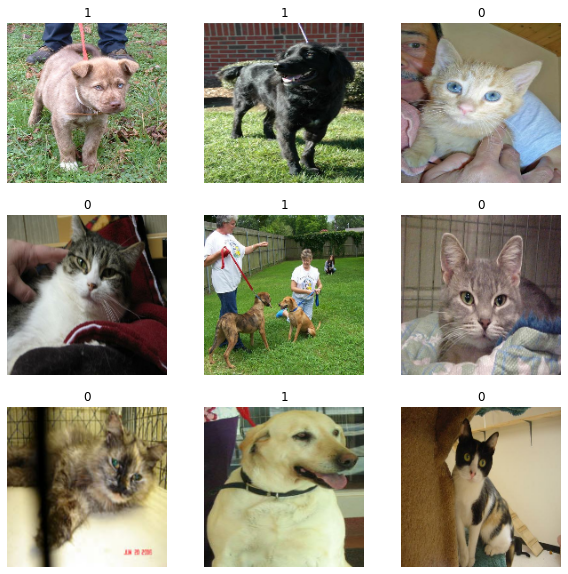

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### **---Image Data Augmentation---**

when you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying


      + RandomFlip
      + RandomRotation



which are realistic transformations to the training images.

+ This helps expose the model to different aspects of training data while slowing down overfitting.

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

Visaulize the Augmented Sampled to check for one image in the dataset.

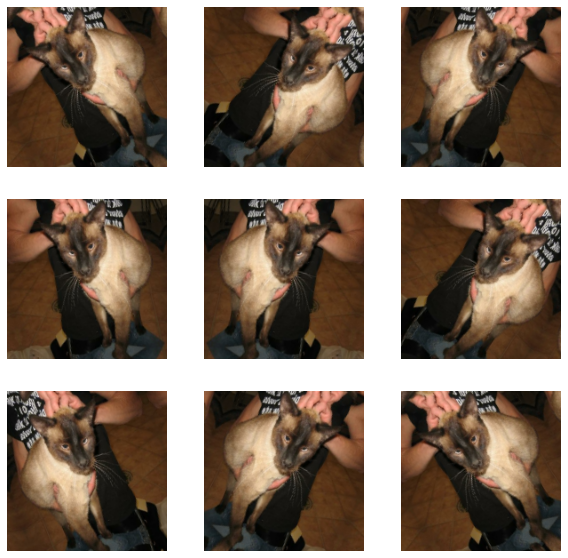

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### **---Standardizing the Data---**

+ The images are in standard size ie, (180,180). But their RGB Channel values are in range [0, 255]. And this is not ideal for a Neural Network. We have to make our input values small as possible.

+ So standardize value to a range of [0, 1] by using Rescaling Layer at the start of the Model.

**Two Ways to do Preprocess the Data**


**1. Make it the Part of Model**
+ In this method, Data Augmentation will happen on Device, synchronously with the rest of the Model Execution. So we will get benefit of GPU Acceleration.

+ Data Augmentation is Inactive at the test time, So input samples will only be augmented during **fit()**, not when calling **evaluate()** or **predict()**.

In [10]:
## Add this code below in the Beginning of the Model ##
"""
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)

"""

...  # Rest of the model

Ellipsis

**2. Apply it to the Dataset**
+ Here Augmentation will happen on CPU, asynchronously and will be buffered before going into the Model.
+ If you are training on CPU,this is the better option - since it will make data augmentation asynchronous and non-blocking.

In [11]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

### **---Configure the Dataset for Perfomance---**

+ Use buffered prefetching, so that we can yield data data from disk without having I/O becoming blocking.

In [12]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

### **---Build the Model---**

+ Build a small version of **Xception Network**
+ Start Model with data augmentation preprocessor followed by **Rescaling Layer**,
+ Include a **Dropout Layer** in the Final Classification Layer.

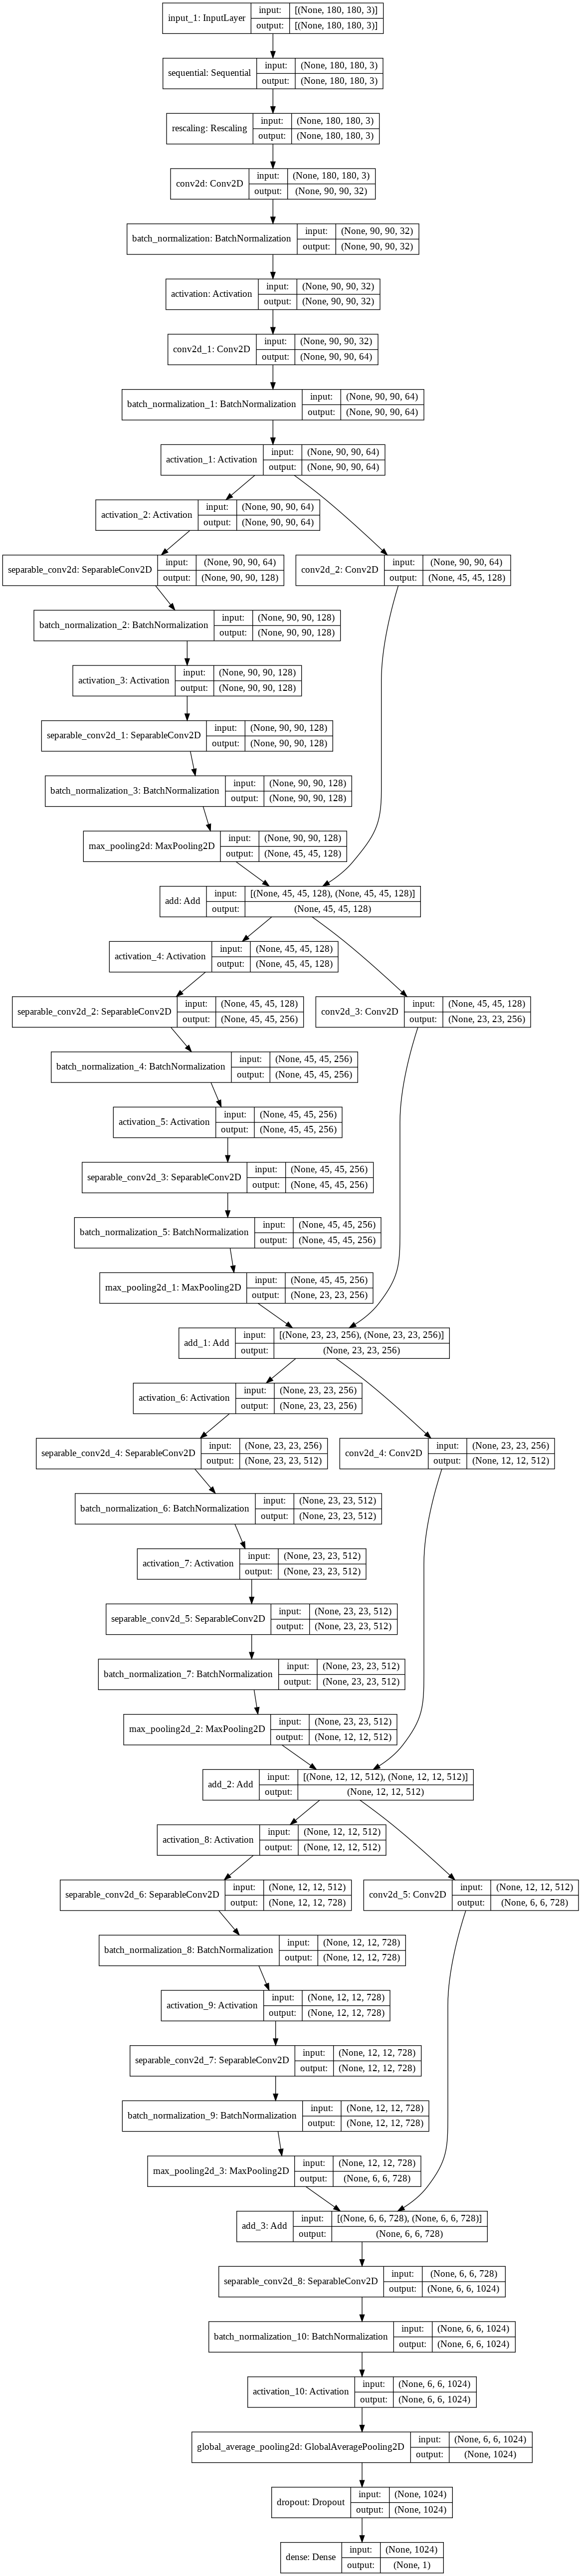

In [13]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

### **---Train Model---**

I'm giving an epoch value to 10, due to Runtime Difficulty. But anyway I believe that won't affect the Model Perfomance Badly.

In [14]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/10
586/586 [==============================] - 162s 259ms/step - loss: 0.6843 - accuracy: 0.6129 - val_loss: 0.6287 - val_accuracy: 0.6450
Epoch 2/10
586/586 [==============================] - 151s 258ms/step - loss: 0.5002 - accuracy: 0.7580 - val_loss: 0.4310 - val_accuracy: 0.8039
Epoch 3/10
586/586 [==============================] - 151s 257ms/step - loss: 0.3870 - accuracy: 0.8240 - val_loss: 0.2968 - val_accuracy: 0.8684
Epoch 4/10
586/586 [==============================] - 151s 257ms/step - loss: 0.3142 - accuracy: 0.8669 - val_loss: 0.2345 - val_accuracy: 0.9073
Epoch 5/10
586/586 [==============================] - 151s 258ms/step - loss: 0.2537 - accuracy: 0.8965 - val_loss: 0.5028 - val_accuracy: 0.7962
Epoch 6/10
586/586 [==============================] - 151s 257ms/step - loss: 0.2093 - accuracy: 0.9137 - val_loss: 0.1764 - val_accuracy: 0.9263
Epoch 7/10
586/586 [==============================] - 151s 257ms/step - loss: 0.2010 - accuracy: 0.9184 - val_loss: 0.2959 -

Here I'm getting a **93% of validation accuracy** after training for 10 epochs on the full data set. But 10 epochs is less when comparing the Optimized training process. With a 50 epochs we can achieve a maximum of **96% of validation accuracy** with this Model.

### **Run Inference on New Data**

Note that, data augmentation and dropout are inactive at inference time

In [15]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 79.72 percent cat and 20.28 percent dog.


So, Here is the out of sample evaluation of the Model. The Model says that the Image which is selected for the Evaluation is a "Cat" image by a Percetage of 80.

+ So the Model is doing well anyway. Not bad Actually.
+ we can Improve the Model Perfomance by increasing the epoch value to a 50.